In [365]:
# imports

import random
from datetime import datetime

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from matplotlib import patches
from torch.utils.data import random_split
from torchvision import transforms

torch.manual_seed(265)
torch.set_default_dtype(torch.double)

In [366]:
path = '../project_zip/data'
train_path = path + '/localization_test.pt'
val_path = path + '/localization_val.pt'
test_path = path + '/localization_test.pt'
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Model parameters
EPOCHS = 10  # Epochs
BATCH_SIZE = 64  # Batch size
KEEP_PROB = 1  # Dropout

#Optimizer parameters
LR = 1e-2  # Learning Rate
BETAS = (0.9, 0.999)  # ADAM Momentum and RSMProp Betas
EPSILON = 1e-8  # ADAM Vanishing and Exploding Gradients
LAMBDA = 1e-4  # L2 Regularization

models = []
model_names = []
loss_train_list = []
loss_val_list = []

In [367]:
train_data = torch.load(train_path)
val_data = torch.load(val_path)
test_data = torch.load(test_path)

In [368]:
#################################
# Train norm
train_all = [x for x, _ in train_data]
trainto_one_tensor = torch.stack(train_all)

mean = trainto_one_tensor.mean()
std = trainto_one_tensor.std()

train_data_n = train_data
train_data.transform = transforms.Normalize(mean, std)

##################################
# Val norm
val_all = [x for x, _ in val_data]
val_to_one_tensor = torch.stack(val_all)

mean = val_to_one_tensor.mean()
std = val_to_one_tensor.std()

val_data_n = val_data
val_data_n.transform = transforms.Normalize(mean, std)

###################################
# Test norm
test_all = [x for x, _ in test_data]
test_to_one_tensor = torch.stack(test_all)

mean = test_to_one_tensor.mean()
std = test_to_one_tensor.std()

test_data_n = test_data
test_data_n.transform = transforms.Normalize(mean, std)


Normalized datasets are now on the form yyy_n

In [369]:
def print_random_img(data):
    x, y = data.__getitem__(random.randint(0, len(data)))
    # (C, H, W)
    print(x.shape)
    tensor_image = transforms.ToPILImage()(x).convert("RGB")
    plt.imshow(tensor_image)
    plt.show()

torch.Size([1, 48, 60])


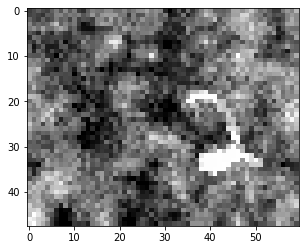

In [370]:
print_random_img(train_data)

Standard LeNet5 Model:

In [371]:
class Net01(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = torch.nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(2),
            torch.nn.Dropout(p=1 - KEEP_PROB)
        )
        self.layer2 = torch.nn.Sequential(
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(2),
            torch.nn.Dropout(p=1 - KEEP_PROB)
        )
        self.layer3 = torch.nn.Sequential(
            nn.Linear(in_features=9 * 12 * 16, out_features=120),
            nn.ReLU(),
            torch.nn.Dropout(p=1 - KEEP_PROB)
        )
        self.layer4 = torch.nn.Sequential(
            nn.Linear(in_features=120, out_features=84),
            nn.ReLU(),
            torch.nn.Dropout(p=1 - KEEP_PROB)
        )
        self.fc5 = nn.Linear(in_features=84, out_features=15)

    def forward(self, x):
        y = self.layer1(x)
        y = self.layer2(y)
        y = y.view(y.shape[0], -1)
        y = self.layer3(y)
        y = self.layer4(y)
        y = self.fc5(y)

        return y

Shallow LeNet5 Model:

In [372]:
class Net02(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = torch.nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=3, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(2),
            torch.nn.Dropout(p=1 - KEEP_PROB)
        )
        self.layer2 = torch.nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(2),
            torch.nn.Dropout(p=1 - KEEP_PROB)
        )
        self.layer3 = torch.nn.Sequential(
            nn.Linear(in_features=9 * 12 * 8, out_features=84),
            nn.ReLU(),
            torch.nn.Dropout(p=1 - KEEP_PROB)
        )
        self.fc4 = nn.Linear(in_features=84, out_features=15)

    def forward(self, x):
        y = self.layer1(x)
        y = self.layer2(y)
        y = y.view(y.shape[0], -1)
        y = self.layer3(y)
        y = self.fc4(y)

        return y

Deep LeNet5 Model:

In [373]:
class Net03(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = torch.nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=12, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(2),
            torch.nn.Dropout(p=1 - KEEP_PROB)
        )
        self.layer2 = torch.nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=32, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(2),
            torch.nn.Dropout(p=1 - KEEP_PROB)
        )
        self.layer3 = torch.nn.Sequential(
            nn.Linear(in_features=9 * 12 * 32, out_features=240),
            nn.ReLU(),
            torch.nn.Dropout(p=1 - KEEP_PROB)
        )
        self.layer4 = torch.nn.Sequential(
            nn.Linear(in_features=240, out_features=168),
            nn.ReLU(),
            torch.nn.Dropout(p=1 - KEEP_PROB)
        )
        self.layer5 = torch.nn.Sequential(
            nn.Linear(in_features=168, out_features=84),
            nn.ReLU(),
            torch.nn.Dropout(p=1 - KEEP_PROB)
        )
        self.fc6 = nn.Linear(in_features=84, out_features=15)

    def forward(self, x):
        y = self.layer1(x)
        y = self.layer2(y)
        y = y.view(y.shape[0], -1)
        y = self.layer3(y)
        y = self.layer4(y)
        y = self.layer5(y)
        y = self.fc6(y)

        return y

Custom loss function:

In [374]:
def myLoss(output, target):
    # Uses BinaryClassification as a  loss function to train the network to recognize if there is a number in the cell or not
    prob = output[:, :1]
    probTarget = target[:, :1]
    loss_fn = nn.BCEWithLogitsLoss()
    loss_prob = loss_fn(prob, probTarget)

    # Creates boolean mask based of if there is a number in the cell and filters out all labels where there is no number
    outputShape = output.shape[1]
    maskOutput = target[:, :1].eq(1).repeat(1, outputShape)
    maskTarget = target[:, :1].eq(1).repeat(1, 6)
    output = torch.masked_select(output, maskOutput)
    target = torch.masked_select(target, maskTarget)
    output = output.reshape(int(output.shape[0] / outputShape), outputShape)
    target = target.reshape(int(target.shape[0] / 6), 6)

    # If there is a number ni the cell it uses MeanSquaredError as a loss function to train the network to find the number's center and its bounding box
    bb = output[:, 1:5]
    bbTarget = target[:, 1:5].to(dtype=torch.double)
    loss_fn = nn.MSELoss()
    loss_bb = loss_fn(bb, bbTarget)

    # If there is a number in the cell it uses CrossEntropy as a loss function to train the network to classify the numbers
    clas = output[:, 5:]
    clasTarget = target[:, 5].to(dtype=torch.long)
    loss_fn = nn.CrossEntropyLoss()
    loss_clas = loss_fn(clas, clasTarget)

    return loss_prob + loss_bb + loss_clas

Train function:

In [375]:
def train(n_epochs, optimizer, model, train_loader, train_mode):
    """
    Train our model and save weight values
    """
    n_batch = len(train_loader)
    losses_train = []
    model.train()
    optimizer.zero_grad(set_to_none=True)

    for epoch in range(1, n_epochs + 1):

        loss_train = 0.0
        for imgs, labels in train_loader:
            imgs = imgs.to(device=device, dtype=torch.double)
            labels = labels.to(device=device)

            outputs = model(imgs)

            loss = myLoss(outputs, labels)
            loss.backward()

            optimizer.step()
            optimizer.zero_grad()

            loss_train += loss.item()

        losses_train.append(loss_train / n_batch)

        print('{}  |  Epoch {}  |  Training loss {:.5f}'.format(
            datetime.now().time(), epoch, loss_train / n_batch))
    train_mode.append(losses_train)

Train N - models


In [376]:
train_loader = torch.utils.data.DataLoader(train_data_n, batch_size=BATCH_SIZE, shuffle=True)
model01 = Net01().to(device=device)
optimizer = optim.Adam(model01.parameters(), lr=LR, betas=BETAS, eps=EPSILON, weight_decay=LAMBDA)
train(EPOCHS, optimizer, model01, train_loader, loss_train_list)
models.append(model01)
model_names.append("LeNet Standard ")

23:44:59.527290  |  Epoch 1  |  Training loss 2.39718
23:45:11.531012  |  Epoch 2  |  Training loss 2.33537
23:45:22.719972  |  Epoch 3  |  Training loss 2.33053
23:45:33.956398  |  Epoch 4  |  Training loss 2.32760
23:45:45.893503  |  Epoch 5  |  Training loss 2.32775
23:45:57.930622  |  Epoch 6  |  Training loss 2.32736
23:46:09.128931  |  Epoch 7  |  Training loss 2.32769
23:46:20.672983  |  Epoch 8  |  Training loss 2.32508
23:46:32.493498  |  Epoch 9  |  Training loss 2.32653
23:46:44.152346  |  Epoch 10  |  Training loss 2.32608


In [377]:
train_loader = torch.utils.data.DataLoader(train_data_n, batch_size=BATCH_SIZE, shuffle=True)
model02 = Net02().to(device=device)
optimizer = optim.Adam(model02.parameters(), lr=LR, betas=BETAS, eps=EPSILON, weight_decay=LAMBDA)
train(EPOCHS, optimizer, model02, train_loader, loss_train_list)
models.append(model02)
model_names.append("LeNet Shallow ")

23:46:49.878549  |  Epoch 1  |  Training loss 2.36746
23:46:55.555490  |  Epoch 2  |  Training loss 2.32969
23:47:01.188545  |  Epoch 3  |  Training loss 2.33306
23:47:06.894650  |  Epoch 4  |  Training loss 2.32191
23:47:12.582789  |  Epoch 5  |  Training loss 2.22838
23:47:18.285151  |  Epoch 6  |  Training loss 2.06632
23:47:23.974342  |  Epoch 7  |  Training loss 1.97308
23:47:29.645321  |  Epoch 8  |  Training loss 1.90372
23:47:35.314613  |  Epoch 9  |  Training loss 1.79666
23:47:41.012192  |  Epoch 10  |  Training loss 1.72412


In [378]:
train_loader = torch.utils.data.DataLoader(train_data_n, batch_size=BATCH_SIZE, shuffle=True)
model03 = Net03().to(device=device)
optimizer = optim.Adam(model03.parameters(), lr=LR, betas=BETAS, eps=EPSILON, weight_decay=LAMBDA)
train(EPOCHS, optimizer, model03, train_loader, loss_train_list)
models.append(model03)
model_names.append("LeNet Deep")

23:47:58.584246  |  Epoch 1  |  Training loss 2.42280
23:48:18.831750  |  Epoch 2  |  Training loss 2.33212
23:48:38.473747  |  Epoch 3  |  Training loss 2.33088
23:48:58.151886  |  Epoch 4  |  Training loss 2.32961
23:49:17.877501  |  Epoch 5  |  Training loss 2.32951
23:49:37.814904  |  Epoch 6  |  Training loss 2.32739
23:49:57.793066  |  Epoch 7  |  Training loss 2.32821
23:50:17.830487  |  Epoch 8  |  Training loss 2.32773
23:50:40.151515  |  Epoch 9  |  Training loss 2.32707
23:51:00.625937  |  Epoch 10  |  Training loss 2.32784


In order to measure our models, we have created this custom accuracy function that can find out how our model performs.
This should count the accuracy of the predicted boudning box as well as the predicted class.

In [379]:
"""
Code is inspired from this youtube video:
https://www.youtube.com/watch?v=XXYG5ZWtjj0&t=160s&ab_channel=AladdinPersson
"""
def intersection_over_union(pred_box: torch.tensor, label_box: torch.tensor):
    # pred_box shape should be (N, 4), where N is the number of bboxs
    # label_box shape is (N, 4)

    box1_x1 = pred_box[..., 0:1] - pred_box[..., 2:3] / 2
    box1_y1 = pred_box[..., 1:2] - pred_box[..., 3:4] / 2
    box1_x2 = pred_box[..., 0:1] + pred_box[..., 2:3] / 2
    box1_y2 = pred_box[..., 1:2] + pred_box[..., 3:4] / 2

    box2_x1 = label_box[..., 0:1] - label_box[..., 2:3] / 2
    box2_y1 = label_box[..., 1:2] - label_box[..., 3:4] / 2
    box2_x2 = label_box[..., 0:1] + label_box[..., 2:3] / 2
    box2_y2 = label_box[..., 1:2] + label_box[..., 3:4] / 2

    x1 = torch.max(box1_x1, box2_x1)
    y1 = torch.max(box1_y1, box2_y1)
    x2 = torch.min(box1_x2, box2_x2)
    y2 = torch.min(box1_y2, box2_y2)

    intersection = (x2 - x1).clamp(0) * (y2 - y1).clamp(0)

    box1_area = abs((box1_x2 - box1_x1) * (box1_y2 - box1_y1))
    box2_area = abs((box2_x2 - box2_x1) * (box2_y2 - box2_y1))

    return intersection / (box1_area + box2_area - intersection + 1e-6)


In [380]:
def find_highest_acc(output):
    output = output.squeeze()
    classes = [x.item() for x in output]

    classes = classes[5:]
    highest_pred = max(classes)
    index = (classes.index(max(classes)))
    # print(f"highest pred: {highest_pred} at {index}")
    return index


def get_vals(tensor: torch.tensor):
    """
    :param tensor:
    :return x, y, w, h:
    """
    tens = tensor[0][1:5].clone().detach()
    return torch.tensor(
        [(int(tens[0] * 60)) - int((tens[2] / 2) * 60),
         int(tens[1] * 48) - int((tens[3] / 2) * 48),
         int(tens[2] * 60),
         int(tens[3] * 48)],
        dtype=torch.int)


def compute_acc(model, loader):
    correct = 0.
    total = 0.
    IoU = 0
    with torch.no_grad():
        model.eval()
        for imgs, labels in loader:
            imgs = imgs.to(device=device, dtype=torch.double)
            labels = labels.to(device=device)
            output = model(imgs)
            IoU += intersection_over_union(get_vals(labels), get_vals(output))
            output = output.squeeze()
            output[5:] = torch.nn.functional.softmax(output[5:].clone(), dim=0)
            true_class = int(labels[0][-1].item())
            predicted_class = find_highest_acc(output)
            if true_class == predicted_class:
                correct += 1
                total += 1
            else:
                total += 1

    return ((correct + IoU) / total).item()

In [381]:
SMOOTH = 1e-6


def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    # You can comment out this line if you are passing tensors of equal shape
    # But if you are passing output from UNet or something it will most probably
    # be with the BATCH x 1 x H x W shape
    # outputs = outputs.squeeze(1)  # BATCH x 1 x H x W => BATCH x H x W
    outputs = outputs.unsqueeze(dim=1)
    labels = outputs.unsqueeze(dim=1)

    print(outputs.shape)
    print(labels.shape)
    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))  # Will be zero if both are 0

    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0

    thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  # This is equal to comparing with thresolds

    return thresholded

Loss of each model

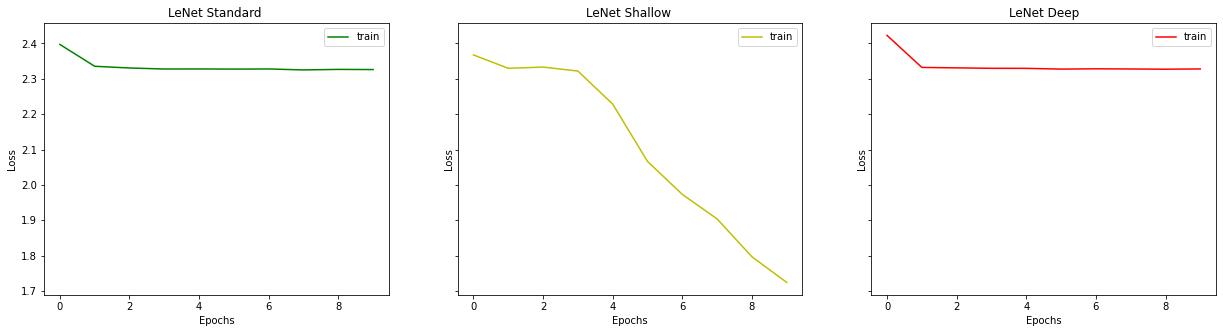

In [382]:
n_model = len(models)

fig, axes = plt.subplots(1, n_model, figsize=(7 * n_model, 5), sharey=True, squeeze=False)

for l_train, name, ax in zip(loss_train_list, model_names, axes.flat):
    ax.plot(l_train, label='train', color=random.choice(['r', 'b', 'y', 'g', 'c', 'm']))
    ax.set_title(str(name))
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.legend()

plt.show()

Best model is:

In [383]:
model_score = []
for i, model in enumerate(models):
    val_loader = torch.utils.data.DataLoader(val_data_n, shuffle=False)
    model_perf = compute_acc(model, val_loader) * 100
    model_score.append(model_perf)
    print(f"Accuracy of model {i + 1} was: {model_perf}")

best_model = models[(model_score.index(max(model_score)))]

Accuracy of model 1 was: 22.150680646793944
Accuracy of model 2 was: 66.0179731171727
Accuracy of model 3 was: 23.319331612517498


In [384]:
def draw_bounding_box_man(pan, true_tup, pred_tup, true_w, pred_w, true_h, pred_h):
    fig, ax = plt.subplots(1)
    ax.imshow(pan)
    true_x = true_tup[0]
    true_y = true_tup[1]
    true_bb = patches.Rectangle((true_x, true_y), true_w, true_h, linewidth=3, edgecolor='r',
                                facecolor='none')
    pred_bb = patches.Rectangle((pred_tup[0], pred_tup[1]), pred_w, pred_h, linewidth=3, edgecolor='b',
                                facecolor='none')

    ax.add_patch(true_bb)
    ax.add_patch(pred_bb)

    plt.show()

Tot parameters: 74621 
Number of param p/layer: [75, 3, 600, 8, 72576, 84, 1260, 15]


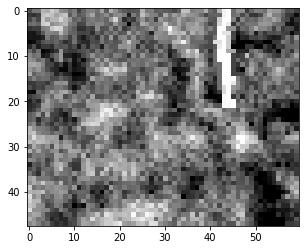

Predicted BB - box coordinates: 
Intersection over union is: 0.0


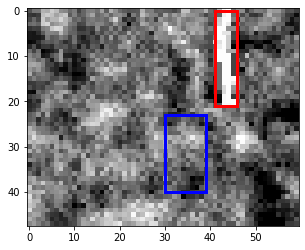

Correct label was: 1
Acc: 7.7469 % for elem 0
Acc: 23.8251 % for elem 1
Acc: 3.3475 % for elem 2
Acc: 4.4369 % for elem 3
Acc: 12.2430 % for elem 4
Acc: 3.2315 % for elem 5
Acc: 8.6055 % for elem 6
Acc: 9.6910 % for elem 7
Acc: 11.0524 % for elem 8
Acc: 15.8202 % for elem 9


In [385]:
num_l = [p.numel() for p in best_model.parameters()]
print(f"Tot parameters: {sum(num_l)} \nNumber of param p/layer: {num_l}")

# We can feed a picture into our model:
img, label = val_data[random.randint(0, len(val_data))]  # choose not normalized data for it to print picture
img = img.to(device=device, dtype=torch.double)

# (C, H, W)
tensor_image = transforms.ToPILImage()(img).convert("RGB")
plt.imshow(tensor_image)
plt.show()

########
# feed image into Model01
best_model.eval()
output_tensor = best_model(img.unsqueeze(0))

bbox = output_tensor[0][1:5].clone().detach()

# true_bbox = label

true_bbox = torch.tensor(
    [(int(label[1] * 60)) - int((label[3] / 2) * 60),
     int(label[2] * 48) - int((label[4] / 2) * 48),
     int(label[3] * 60),
     int(label[4] * 48)],
    dtype=torch.int)
true_bb = [x.item() for x in true_bbox]

print("Predicted BB - box coordinates: ")
pred_bbox = torch.tensor(
    [(int(bbox[0] * 60)) - int((bbox[2] / 2) * 60),
     int(bbox[1] * 48) - int((label[3] / 2) * 48),
     int(bbox[2] * 60),
     int(bbox[3] * 48)],
    dtype=torch.int)

t1_box1 = bbox[0:4].clone().detach()
lt1_box2 = label[1:5].clone().detach()
# tmp = intersection_over_union(t1_box1, lt1_box2)
tmp = intersection_over_union(pred_bbox, true_bbox)
print(f"Intersection over union is: {tmp[0].item() * 100}")

pred_bb = [x.item() for x in pred_bbox]
draw_bounding_box_man(tensor_image, (true_bb[0], true_bb[1]), (pred_bb[0], pred_bb[1]), true_bb[2], pred_bb[2],
                      true_bb[3], pred_bb[3])

print(f"Correct label was: {int(label[-1])}")
print("=" * 24, end="\n")

classes_ = torch.nn.functional.softmax(output_tensor[:, 5:], dim=1)  # output_tensor[0, 5:], dim=1)

for i, pred in enumerate(classes_.squeeze()):
    print("Acc: {pred:.4f} % for elem {i}".format(pred=pred * 100, i=i))
    # print(f"Acc: {pred} for elem {i}")


After the best model has been choosen, we need to evaluate the best model by testing it with our test data set.

In [386]:
test_set_checker = torch.utils.data.DataLoader(test_data_n, shuffle=True)
tmp = compute_acc(model02, test_set_checker)
print(f"The accuracy of the best model is: {tmp*100}")

The accuracy of the best model is: 72.47698400812781
